# Rebalancing Benchmark for Catboost MultiClass Classification

Since only 22 songs are proposed each day on the 2k dataset, the class are unbalanced with the following proportions : <br/>
- 50 : 0,18%
- 40 : 0,18%
- 30 : 0,18%
- 20 : <0,18%
- 10 : <0,18%
- MC : 0,09%
- 20k : 0,18%
- PP : 99,02%

Hence, we clearly have an unbalanced dataset and we need to address this problem

## I. Dataset loading

In [47]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
import sklearn.metrics as skl
import matplotlib.pyplot as plt
import os
import util

os.chdir("C:/Users/thoma/OneDrive - CentraleSupelec/NOPLP/code/ML")

# Chargement du dataset
print("Dataset loading...")
df = pd.read_csv("data/lossBenchmarkData.csv", sep=";")

# Data Cleaning
print("Data cleaning...")
df = df.drop(columns=['Unnamed: 0', 'id', 'Chanson_id'])
reversed_cat = {'50': 1, '40': 2, '30': 3,
                '20': 4, '10': 5, 'MC': 6, '20k': 7, None: 8}
df = df.replace({'categorie': reversed_cat})

# Split train / test
print("Spliting in train and test...")
train = df[0:int(len(df)*0.8)]
print("Taille du dataset de train : " + str(len(train)))
test = df[int(len(df)*0.8)+1:]
print("Taille du dataset de test : " + str(len(test)))
train_labels = train['categorie']
trainSL = train.drop(columns=['categorie'])
train_data = trainSL
test_labels = test['categorie']
test = test.drop(columns=['categorie'])
test_data = test
test_pool = Pool(test_data,
                 test_labels,
                 cat_features=['titre', 'artiste'])

Dataset loading...
Data cleaning...
Spliting in train and test...
Taille du dataset de train : 206130
Taille du dataset de test : 51532


## II. Sans rééquilibrage

Let see what happens without rebalancing the dataset

In [2]:
# Training model
print("Training the CatBoost model...")
model = CatBoostClassifier(iterations=10,
                           depth=10,
                           learning_rate=1,
                           loss_function='MultiClass',
                           verbose=True)
model.fit(train_data, train_labels, cat_features=[
          'titre', 'artiste'])

Training the CatBoost model...
0:	learn: 0.0835630	total: 2.45s	remaining: 22.1s
1:	learn: 0.5917520	total: 4.64s	remaining: 18.6s
2:	learn: 1.1319395	total: 6.69s	remaining: 15.6s
3:	learn: 1.1233489	total: 8.98s	remaining: 13.5s
4:	learn: 1.1151886	total: 11.5s	remaining: 11.5s
5:	learn: 1.0755618	total: 13.9s	remaining: 9.25s
6:	learn: 1.0442403	total: 16.1s	remaining: 6.92s
7:	learn: 1.0639025	total: 18.3s	remaining: 4.58s
8:	learn: 1.0210985	total: 20.5s	remaining: 2.27s
9:	learn: 1.0189583	total: 22.7s	remaining: 0us


Predicting on the test set...
Confusion matrix :


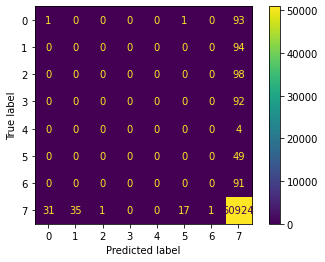

In [4]:
# Prediction on test set
print("Predicting on the test set...")
preds_class = model.predict(test_pool)
preds_proba = model.predict_proba(test_pool)
preds = model.predict_log_proba(test_pool)

# Modification du dataset de test
test_data["pred"] = preds_class
test_data["labels"] = test_labels
test_data[["1", "2", "3", "4", "5", "6", "7", "8"]] = preds

# Confusion matrix
print("Confusion matrix :")
test_data["pred"] = preds_class
test_data["labels"] = test_labels
confusionMatrix = skl.confusion_matrix(
    test_data['labels'], test_data['pred'])
dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
dispCM.plot()
plt.show()

## III. Metric definition

First, what is the most precious information for us to get is about the Mêmes Chansons and te 20k Chansons. We will thus create a metric that only takes into account these two classes. <br/>
We want two things : <br/>
- We **absolutely** don't want to miss songs, especially MC songs
- We don't want to learn too many songs, because, physically, we can revise only 20-30 songs per day

For the first requirement, we will consider the precisions on the two classes that we care about. Let $a_{ij}$ be the coefficient at the $i-th$ row and $j-th$ column of the confusion matrix :
$$P_5 = \frac{a_{55}}{\sum_{j = 0}^7a_{5j}}$$
The same expression can be obtained for the 20k songs replacing 5 by 6.
Then, since we absolutely don't want to miss MC songs, we can't compute a weighted mean of the two metrics with a higher weight for $P_5$.
$$Precision(\lambda) = \lambda P_5 + (1-\lambda) P_6$$
We will take $\lambda = 0.9$

For the second requirement, we will do the same work with the recalls on both classes.
$$R_5 = \frac{a_{55}}{\sum_{i = 0}^7a_{i5}}$$
Then,
$$Recall(\mu) = \mu R_5 + (1-\mu) R_6$$
Let's take $\mu = 0.5$

We then compute a classical $F1-score$ with knowing the precision and the recall of the problem :
$$F1 = \frac{2}{\frac{1}{Precision(\lambda)} + \frac{1}{Recall(\mu)}}$$

### 1. Application for the test case without rebalancing

In [44]:
def precisionOrRecall(metric, c):
    res = 0
    if metric == "Precision":
        res = confusionMatrix[c, c]/sum(confusionMatrix[c,])
    elif metric == "Recall":
        res = confusionMatrix[c, c]/sum(confusionMatrix[:,c])
    else:
        raise("metric argument must be either Precision or Recall")
    return round(res * 100, 1)

def F1score(p, r):
    if p == 0 and r == 0:
        return 0
    else:
        return round(2/(1/p + 1/r), 1)

# Calcul de la précision
P5 = precisionOrRecall("Precision", 5)
print("P5 = {0}".format(P5))
P6 = precisionOrRecall("Precision", 6)
print("P6 = {0}".format(P6))
l = 0.9
precision = l*P5 + (1-l)*P6
print("Precision = {0}".format(precision))

# Calcul du recall
R5 = precisionOrRecall("Recall", 5)
print("R5 = {0}".format(R5))
R6 = precisionOrRecall("Recall", 6)
print("R6 = {0}".format(R6))
mu = 0.5
recall = mu*R5 + (1-mu)*R6
print("Recall = {0}".format(recall))

# Calcul du F1-score
F1 = F1score(precision, recall)
print("F1-score = {0}".format(F1))

P5 = 30.6
P6 = 18.7
Precision = 29.410000000000004
R5 = 0.9
R6 = 0.8
Recall = 0.8500000000000001
F1-score = 1.7


**Conclusion :** Si on n'utilise pas de méthode de rebalancing, les résultats sont pourris

## IV. Echantillonage en enlevant des PP

La première stratégie consiste, pour chaque émission, à ne pas garder l'ensemble des chansons du dataset qui ne sont pas passées. On en garde seulement une proportion $\tau$, quitte à faire baisser la taille de l'échantillon.

Pour ce faire, on split le dataset entre les chansons qui ne passent pas $PP$ et celles qui passent $P$, puis on concatène $dataset = P + \tau PP$

In [36]:
def buildDataset(df, tau):
    P = df[df.categorie != 8]
    PP = df[df.categorie == 8]
    tauPP = PP.sample(frac = tau)
    res = pd.concat([P, tauPP])
    return res

exempleBuildDataset = buildDataset(train, 0.01)
exempleBuildDataset.sample(5)

,titre,année,decennie,artiste,clusterid,deltadate,deltadatemc,deltadatemcma,deltadate20k,deltadate20kma,tauxchoisies,categorie
177605,Le chanteur abandonné,1985,1980,Hallyday Johnny,3,50.0,NaN,63.0,279.0,59.0,0.5,8
12225,Bambou,1981,1980,Chamfort Alain,2,55.0,NaN,104.0,170.0,73.0,0.0,2
110243,Belle,1998,1990,Notre-Dame de Paris,3,170.0,235.0,127.0,NaN,NaN,1.0,1
167543,Le rire du sergent,1971,1970,Sardou Michel,1,152.0,NaN,70.0,NaN,39.0,1.0,7
186957,Gaby oh Gaby,1980,1980,Bashung Alain,1,43.0,462.0,291.0,NaN,109.0,0.4,8


### 1. Petit test avec $\tau = 1\%$

Ici on a pris $\tau = 1\%$, entrainons le modèle et calculons le F1-score

Training the CatBoost model...
0:	learn: 1.5654648	total: 217ms	remaining: 1.95s
1:	learn: 1.4292185	total: 438ms	remaining: 1.75s
2:	learn: 1.3366872	total: 654ms	remaining: 1.52s
3:	learn: 1.2811790	total: 940ms	remaining: 1.41s
4:	learn: 1.1906658	total: 1.23s	remaining: 1.23s
5:	learn: 1.1291866	total: 1.51s	remaining: 1s
6:	learn: 1.0722350	total: 1.8s	remaining: 771ms
7:	learn: 0.9936019	total: 2.02s	remaining: 504ms
8:	learn: 0.9536021	total: 2.22s	remaining: 247ms
9:	learn: 0.8924762	total: 2.43s	remaining: 0us
Predicting on the test set...
Confusion matrix :


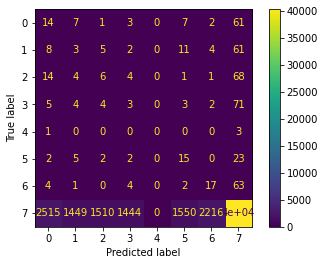

In [37]:
# Split train / test
train_labels = exempleBuildDataset['categorie']
trainSL = exempleBuildDataset.drop(columns=['categorie'])
train_data = trainSL

# Training model
model = util.trainModel(train_data, test_data, ['titre', 'artiste'])

# Prediction on test set
print("Predicting on the test set...")
preds_class = model.predict(test_pool)
preds_proba = model.predict_proba(test_pool)
preds = model.predict_log_proba(test_pool)

# Modification du dataset de test
test_data["pred"] = preds_class
test_data["labels"] = test_labels
test_data[["1", "2", "3", "4", "5", "6", "7", "8"]] = preds

# Confusion matrix
print("Confusion matrix :")
test_data["pred"] = preds_class
test_data["labels"] = test_labels
confusionMatrix = skl.confusion_matrix(
    test_data['labels'], test_data['pred'])
dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
dispCM.plot()
plt.show()

In [45]:
# Calcul de la précision
P5 = precisionOrRecall("Precision", 5)
print("P5 = {0}".format(P5))
P6 = precisionOrRecall("Precision", 6)
print("P6 = {0}".format(P6))
l = 0.9
precision = round(l*P5 + (1-l)*P6, 1)
print("Precision = {0}".format(precision))

# Calcul du recall
R5 = precisionOrRecall("Recall", 5)
print("R5 = {0}".format(R5))
R6 = precisionOrRecall("Recall", 6)
print("R6 = {0}".format(R6))
mu = 0.5
recall = round(mu*R5 + (1-mu)*R6, 1)
print("Recall = {0}".format(recall))

# Calcul du F1-score
F1 = F1score(precision, recall)
print("F1-score = {0}".format(F1))

P5 = 30.6
P6 = 18.7
Precision = 29.4
R5 = 0.9
R6 = 0.8
Recall = 0.8
F1-score = 1.6


### 2. Recherche de la proportion $\tau$ optimale

On va itérer sur les différentes valeurs de $\tau$ suivantes : $\{0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1\}$ et regarder l'évolution des trois métriques suivantes : précision, recall et F1-score.

Training the CatBoost model...
0:	learn: 1.7474088	total: 220ms	remaining: 1.98s
1:	learn: 1.5704572	total: 430ms	remaining: 1.72s
2:	learn: 1.4422614	total: 673ms	remaining: 1.57s
3:	learn: 1.3787587	total: 941ms	remaining: 1.41s
4:	learn: 1.3108324	total: 1.18s	remaining: 1.18s
5:	learn: 1.2278119	total: 1.45s	remaining: 966ms
6:	learn: 1.1653845	total: 1.65s	remaining: 706ms
7:	learn: 1.0730652	total: 1.86s	remaining: 464ms
8:	learn: 1.0171107	total: 2.05s	remaining: 227ms
9:	learn: 0.9335247	total: 2.3s	remaining: 0us
Predicting on the test set...
Confusion matrix :
P5 = 42.9
P6 = 42.9
Precision = 42.9
R5 = 0.8
R6 = 0.4
Recall = 0.6
F1-score = 1.2
Training the CatBoost model...
0:	learn: 1.7796308	total: 271ms	remaining: 2.44s
1:	learn: 1.6205376	total: 521ms	remaining: 2.08s
2:	learn: 1.5254200	total: 751ms	remaining: 1.75s
3:	learn: 1.4446656	total: 953ms	remaining: 1.43s
4:	learn: 1.3432789	total: 1.16s	remaining: 1.16s
5:	learn: 1.2726564	total: 1.35s	remaining: 903ms
6:	learn:

c:\Users\thoma\OneDrive - CentraleSupelec\NOPLP\code\ML\util.py:130: RuntimeWarning: invalid value encountered in longlong_scalars
  res = confusionMatrix[c, c]/sum(confusionMatrix[:, c])
c:\Users\thoma\OneDrive - CentraleSupelec\NOPLP\code\ML\util.py:140: RuntimeWarning: divide by zero encountered in double_scalars
  return round(2/(1/p + 1/r), 1)


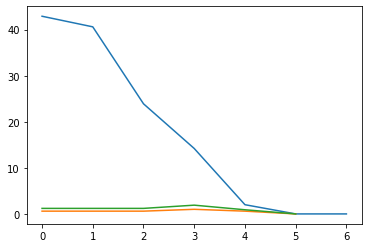

In [48]:
# Définition des listes de stockage des résultats
taus = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]
precisions, recalls, F1scores = [], [], []

for tau in taus:
    
    # Fabrication du dataset de train
    dataset = buildDataset(train, tau)

    # Split train / test
    train_labels = dataset['categorie']
    trainSL = dataset.drop(columns=['categorie'])
    train_data = trainSL

    # Training model
    model = util.trainModel(train_data, train_labels, ['titre', 'artiste'])

    # Confusion matrix
    confusionMatrix = util.confusionMatrixCalculation(model, test_pool, test_data, test_labels)

    # Calcul des métriques
    metriques = util.metricCalculation(confusionMatrix)
    precisions.append(metriques["Precision"])
    recalls.append(metriques["Recall"])
    F1scores.append(metriques["F1score"])

plt.plot(precisions)
plt.plot(recalls)
plt.plot(F1scores)
plt.show()